In [1]:
import pandas as pd
import geopandas as gpd
from os import listdir
from os.path import join
import r5py

# Loading transit network

In [2]:
listGTFSpaths = [
    '../gtfsData/busesEMT_9may2025.zip', # buses EMT
    '../gtfsData/metro_30may2025.zip', # metro
    '../gtfsData/metroLigero_26feb2025.zip', # metro ligero
    '../gtfsData/cercanias_23july2025_fromRenfe.zip' # cercanias
] + [join('../gtfsData/busesInterurbanos_Urbanos_all_16july2025/', i) for i in listdir('../gtfsData/busesInterurbanos_Urbanos_all_16july2025/')]

madridOSMpath = '../osmData/madrid-latest.osm.pbf' 

transport_network = r5py.TransportNetwork(
    madridOSMpath,
    listGTFSpaths,
    allow_errors=True
)

In [ ]:
gpd.GeoSeries(transport_network.extent).set_crs('EPSG:4326').explore()

# origins and destinations


## origins

In [3]:
madridGrid = gpd.read_file('../populationData/madridBarrios_clippedESTAT2021.gpkg').set_crs('EPSG:3035').to_crs("EPSG:4326")[['GRD_ID', 'T', 'M', 'F', 'geometry']]
madridGrid.explore()

<Axes: >

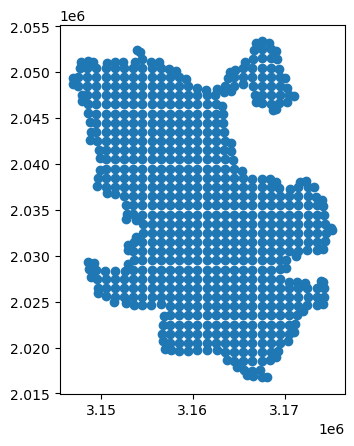

In [4]:
pointOrigins = madridGrid.copy().to_crs('EPSG:3035')
pointOrigins['geometry'] = pointOrigins['geometry'].centroid
pointOrigins.to_crs(madridGrid.crs)
pointOrigins = pointOrigins.rename({'GRD_ID' : 'id'}, axis=1)

pointOrigins.plot()

## destinations

we will have the following destinations:
- libaries
- schools at the infantil, primaria and secundaria level
- universities
- health centers
- other health centers like elderly homes and shelters
- places of worship

We will begin with libraries as this is a small and easy to understand set that will help us see if our approach works.

In [8]:
gdf_libraries = gpd.read_file('../POIs/bibliotecas/cleaned/bibliotecasTodo.geojson').rename({'PK' : 'id'}, axis=1)

pointDestinations = gdf_libraries.to_crs('EPSG:3035') # in this case this geoDataFrame is already in this CRS, but it is good practice to set them all to this to have things consistent


gdf_libraries.shape

(240, 8)

In [ ]:
gdf_colegios = gpd.read_file()

# Generating matrix

In [9]:
import datetime

travel_time_matrix = r5py.TravelTimeMatrix(
    transport_network= transport_network,
    origins = pointOrigins,
    destinations = pointDestinations,
    transport_modes = [r5py.TransportMode.TRANSIT],
    departure=datetime.datetime(2025, 7, 28, 14, 0, 0)
)

travel_time_matrix = pd.DataFrame(travel_time_matrix)

In [10]:
travel_time_matrix.dropna().sort_values(by='travel_time', ascending=False)

,from_id,to_id,travel_time
6854,CRS3035RES1000mN2019000E3169000,9712656915,119.0
32349,CRS3035RES1000mN2025000E3166000,205060159,119.0
95240,CRS3035RES1000mN2036000E3166000,300709861,119.0
95867,CRS3035RES1000mN2036000E3169000,4794233143,119.0
32283,CRS3035RES1000mN2025000E3166000,7222611268,119.0
...,...,...,...
66974,CRS3035RES1000mN2031000E3167000,1745,4.0
25703,CRS3035RES1000mN2024000E3165000,1748,3.0
88825,CRS3035RES1000mN2035000E3165000,1750,3.0
55218,CRS3035RES1000mN2029000E3161000,6893633,2.0


In [12]:
travel_time_matrix.to_csv('./timeMatrices/bibliotecas/desdeMadrid.csv')